In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import glob
import os
import rasterio
import xarray as xr
import scipy

In [238]:
models = ["SMHI-RCA", "MPICSC-REMO1", "DMI-HIRHAM"]
variants = ["RCP85", "RCP45", "RCP26"]
variables = ["tas", "tasmax"]
years = range(2031, 2041)

models_dict = {model: {variant: glob.glob("../data/prognosedaten/*"+"_"+"*"+model+"*"+variant+"*"+".nc") for variant in variants} for model in models}
models_dict2 = {model: {variant: {re.split("_",os.path.basename(filename))[0]:os.path.basename(filename)  for filename in filenames} for variant, filenames in variant.items()} for model, variant in models_dict.items()}

In [239]:
models_dict



{'SMHI-RCA': {'RCP85': ['../data/prognosedaten/tas_SMHI-RCA-HADGEM-EUR44-RCP85_QM_1981-2099_10-229_2-102_mask.nc',
   '../data/prognosedaten/tasmax_SMHI-RCA-HADGEM-EUR44-RCP85_QM_1981-2099_10-229_2-102_mask.nc'],
  'RCP45': ['../data/prognosedaten/tasmax_SMHI-RCA-HADGEM-EUR44-RCP45_QM_1981-2099_10-229_2-102_mask.nc',
   '../data/prognosedaten/tas_SMHI-RCA-HADGEM-EUR44-RCP45_QM_1981-2099_10-229_2-102_mask.nc'],
  'RCP26': ['../data/prognosedaten/tas_SMHI-RCA-HADGEM-EUR44-RCP26_QM_1981-2099_10-229_2-102_mask.nc',
   '../data/prognosedaten/tasmax_SMHI-RCA-HADGEM-EUR44-RCP26_QM_1981-2099_10-229_2-102_mask.nc']},
 'MPICSC-REMO1': {'RCP85': ['../data/prognosedaten/tasmax_MPICSC-REMO1-MPIESM-EUR11-RCP85_QM_1981-2099_10-229_2-102_mask.nc',
   '../data/prognosedaten/tas_MPICSC-REMO1-MPIESM-EUR11-RCP85_QM_1981-2099_10-229_2-102_mask.nc'],
  'RCP45': ['../data/prognosedaten/tasmax_MPICSC-REMO1-MPIESM-EUR11-RCP45_QM_1981-2099_10-229_2-102_mask.nc',
   '../data/prognosedaten/tas_MPICSC-REMO1-MPIESM

In [3]:
ds = xr.open_mfdataset(models_dict["MPICSC-REMO1"]["RCP85"])

ds

<xarray.Dataset>
Dimensions:  (lon: 220, lat: 101, time: 43464)
Coordinates:
  * lon      (lon) float64 5.938 5.958 5.979 6.0 ... 10.44 10.46 10.48 10.5
  * lat      (lat) float64 45.77 45.79 45.81 45.83 ... 47.79 47.81 47.83 47.85
  * time     (time) datetime64[ns] 1981-01-01T12:00:00 ... 2099-12-31T12:00:00
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(43464, 101, 220), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(43464, 101, 220), meta=np.ndarray>
Attributes:
    history:  Fri May 12 16:47:06 2017: ncatted -O -a units,tasmin,m,c,degree...

In [ ]:
# boilerplate
# [[filenames for variant, filenames in variant.items()] for model, variant in models_dict.items()]

In [45]:
prognosis_all = {model: {variant: xr.open_mfdataset(filenames) for variant, filenames in variant.items()} for model, variant in models_dict.items()}

In [4]:
# what dimensions does the netCDF file have?
ds.dims

# the shape of lon 220 cells (each 2km) east-west, looks correct
# the shape of lat 101 cells (each 2km) north-south, looks correct
# the shape of time 43'434 days, ~118 days (1981-2099) looks correct

Frozen({'lon': 220, 'lat': 101, 'time': 43464})

In [5]:
# What variables does the dataset have?
ds.coords

Coordinates:
  * lon      (lon) float64 5.938 5.958 5.979 6.0 ... 10.44 10.46 10.48 10.5
  * lat      (lat) float64 45.77 45.79 45.81 45.83 ... 47.79 47.81 47.83 47.85
  * time     (time) datetime64[ns] 1981-01-01T12:00:00 ... 2099-12-31T12:00:00

In [6]:
# sadly, not many attributes attached to the dataset
for key, val in ds.attrs.items():
    print(key, val, "\n")

history Fri May 12 16:47:06 2017: ncatted -O -a units,tasmin,m,c,degrees_C tasmin_only_atts.nc
Fri May 12 15:34:04 2017: ncatted -O -a method,tasmin,c,c,Bias-corrected and downscaled by QM tasmin_CLMCOM-CCLM4-MPIESM-EUR11-RCP85_QM_1981-2099_test_write_only_atts.nc 



In [26]:
# I can extract a specific range like so:
ds.sel(time = slice("2031-04-01", "2031-09-30"))

<xarray.Dataset>
Dimensions:  (lon: 220, lat: 101, time: 183)
Coordinates:
  * lon      (lon) float64 5.938 5.958 5.979 6.0 ... 10.44 10.46 10.48 10.5
  * lat      (lat) float64 45.77 45.79 45.81 45.83 ... 47.79 47.81 47.83 47.85
  * time     (time) datetime64[ns] 2031-04-01T12:00:00 ... 2031-09-30T12:00:00
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(183, 101, 220), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(183, 101, 220), meta=np.ndarray>
Attributes:
    history:  Fri May 12 16:47:06 2017: ncatted -O -a units,tasmin,m,c,degree...

Text(0.5, 1.0, 'SMHI-RCA')

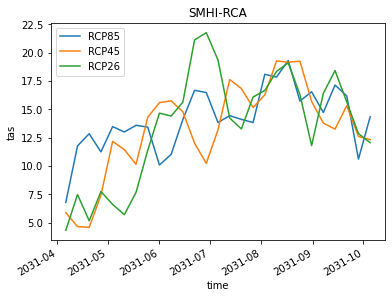

In [75]:
# debugging
for variant in variants:
    prognosis_all[models[0]][variant].sel(time = slice("2031-04-01", "2031-09-30"), lon = slice(minx, maxx), lat = slice(miny, maxy)).tas.resample(time = "W").mean().mean(("lon","lat")).plot(label = variant)
plt.legend()
plt.title(models[0])

#plt.savefig("../plots/"+models[0]+".tif")

Text(0.5, 1.0, 'SMHI-RCA')

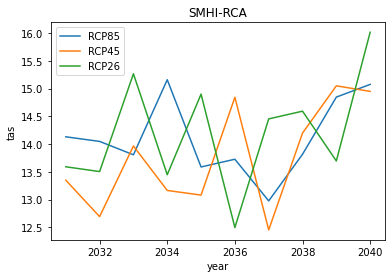

In [97]:
# debugging
model = models[0]

for variant in variants:
    xr.concat([prognosis_all[model][variant].sel(time = slice(str(year)+"-04-01", str(year)+"-09-30"), lon = slice(minx, maxx), lat = slice(miny, maxy)) for year in years], pd.Index(years, name = "year")).tas.groupby("year").mean(...).plot(label = variant)
plt.legend()
plt.title(model)


In [175]:
# debugging
def mean_summmer_temp(x, var, model, variant, years = range(2031, 2041),minx=7.810030844025151, miny=46.757013088082914,maxx=8.540348762846177, maxy=47.305180036206615):
    return xr.concat([x[model][variant][var].sel(time = slice(str(year)+"-04-01", str(year)+"-09-30"), lon = slice(minx, maxx), lat = slice(miny, maxy)) for year in years], pd.Index(years, name = "year")).groupby("year").mean(...)
    


mean_summer_temp_vals = xr.concat([xr.concat([mean_summmer_temp(prognosis_all, "tas",model, variant) for model in models], pd.Index(models, name = "models")) for variant in variants], pd.Index(variants, name = "variants"))


In [179]:
mean_summer_temp_vals

<xarray.DataArray 'tas' (variants: 3, models: 3, year: 10)>
dask.array<concatenate, shape=(3, 3, 10), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * year      (year) int64 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040
  * models    (models) object 'SMHI-RCA' 'MPICSC-REMO1' 'DMI-HIRHAM'
  * variants  (variants) object 'RCP85' 'RCP45' 'RCP26'

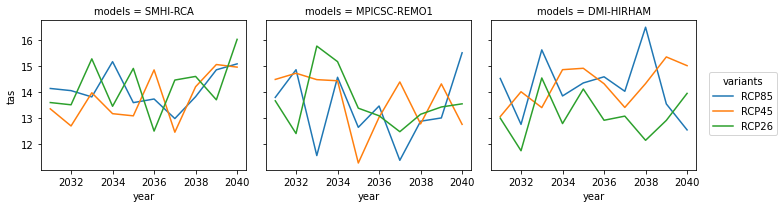

In [186]:
# debugging
mean_summer_temp_vals.plot.line(x = "year", col = "models")
#plt.title("Yearly mean of mean daily temperature during the summer\nmonths (1.4-30.9) for the years "+pretty_range(years))

plt.savefig("../output/plots/mean_daily_temp_year.pdf")

In [323]:
models_df = pd.concat([pd.DataFrame.from_dict(models_dict2[model]).reset_index().assign(model = model) for model in models])

models_df = models_df.melt(["model","index"]).rename(columns = {"value":"filename", "variable": "variant", "index":"variable"}).sort_values(["model","variant"])

models_df = models_df[['model', 'variant', 'variable','filename']]

models_df.to_csv("../output/models-filenames.csv", index = False)


In [137]:
# debugging
# warning, takes a long time
mean_summer_temp_df = mean_summer_temp_vals.to_pandas()

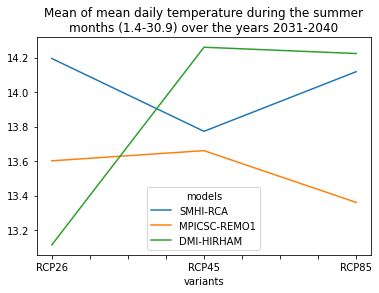

In [174]:
# debugging
def pretty_range(x, sep = "-"):
    li = [y for y in x]
    return str(min(li))+sep+str(max(li))

mean_summer_temp_df.sort_index().plot()

plt.title("Mean of mean daily temperature during the summer\nmonths (1.4-30.9) over the years "+pretty_range(years))
    

plt.savefig("../output/plots/mean_daily_temp.pdf")

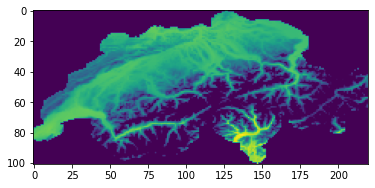

In [8]:
def hugglin_index(x):
    return (((x.tas-10)+(x.tasmax-10))/2)*1.045

ds_hugg = (ds.sel(time = slice("2031-04-01", "2031-09-30")) # extracts a specific period from the dataset
    .groupby("time")                                        # groups the dataset by time
    .map(hugglin_index)                                     # maps the function "hugglin_index" (see above) for each day
    .sum(dim="time"))                                       # sums up all daily values

ds_hugg = (ds_hugg
    .where(ds_hugg > 0, other = 0)                          # replaces values below 0 with 0
    .fillna(0))                                             # replaces NaN values with 0 (not tested)

plt.imshow(np.flip(ds_hugg, 0))

In [9]:
# turn the above process into a function
def hugglin_year(x, year):
    y = x.sel(time = slice(str(year)+"-04-01", str(year)+"-09-30")).groupby("time").map(hugglin_index).sum(dim="time")
    y = y.where(y > 0, other = 0).fillna(0)
    return y

# also, create a helperfunction to plot results.
def plot(x):
    plt.imshow(np.flip(x, 0))

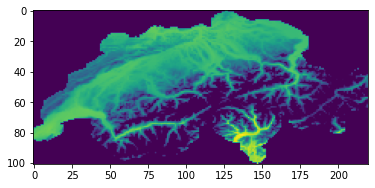

In [10]:
plot(hugglin_year(ds, 2031))


What I need to calculate is the following (pseudocode):

```
for years in 2031-2040:
    for days in 30.09.year-01.04.(year+1):
        ((tas-10)+(tas_max-10))/2*1.045
        
```


In [11]:
# Import the kanton of luzern ....
kantonsgrenze = gpd.read_file("../data/swissBOUNDARIES3D_1_3_LV95_LN02.gdb/", layer = "TLM_KANTONSGEBIET").query("NAME == 'Luzern'") # fiona.listlayers("data/swissBOUNDARIES3D_1_3_LV95_LN02.gdb/")

# buffer it with 2km, transform it to wsg84 and get the bounding box
kanton_bounds = kantonsgrenze.buffer(2000).to_crs(4326).bounds.reset_index(drop = True).to_dict()
kanton_bounds = {key: val[0] for key, val in kanton_bounds.items()}

In [12]:
kanton_bounds

{'minx': 7.810030844025151,
 'miny': 46.757013088082914,
 'maxx': 8.540348762846177,
 'maxy': 47.305180036206615}

In [13]:
# make sure that the order of the variables maches the order above
minx, miny, maxx, maxy = kanton_bounds.values()

Just as slicing over time, we can slice over lon / lat

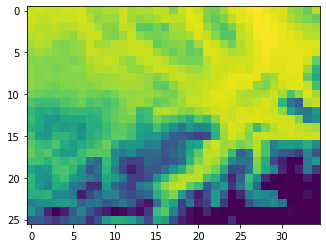

In [14]:
ds_hugg_lu = ds.sel(time = slice("2031-04-01", "2031-09-30"), lon = slice(minx, maxx), lat = slice(miny, maxy)).groupby("time").map(hugglin_index).sum(dim="time")
ds_hugg_lu = ds_hugg_lu.where(ds_hugg_lu>0, other = 0)
plot(ds_hugg_lu)

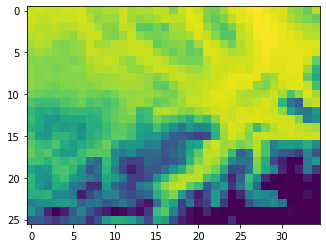

In [15]:
def hugglin_bbox(x, year, minx, maxx, miny, maxy):
    y = x.sel(lon = slice(minx, maxx), lat = slice(miny, maxy))
    y = hugglin_year(y, year)
    y.name = str(year)
    return y

plot(hugglin_bbox(ds, 2031, minx, maxx, miny, maxy))

In [20]:
def hugglin_variants(filenames, variant):
    ds = xr.open_mfdataset(filenames)
    ds_hugg = xr.concat([hugglin_bbox(ds, year, minx, maxx, miny, maxy) for year in years], "year").mean(dim = "year")
    ds_hugg.name = variant
    return ds_hugg

# this is almost exactly the same as hugglin_variants, see if you can replace it
def open_and_name(filenames, name):
    ds = xr.open_mfdataset(filenames)
    ds.name = name
    return ds

def my_concat(x, dimname, newname = ""):
    y = xr.concat(x, dim = pd.Index([y.name for y in x], name = dimname))
    if newname != "":
        y.name = newname
    return y

def my_open_mfdataset(x):
    return [xr.open_dataarray(y) for y in x]

In [25]:
open_mf

['../data/prognosedaten/tas_SMHI-RCA-HADGEM-EUR44-RCP85_QM_1981-2099_10-229_2-102_mask.nc',
 '../data/prognosedaten/tasmax_SMHI-RCA-HADGEM-EUR44-RCP85_QM_1981-2099_10-229_2-102_mask.nc']

In [98]:
huggin_prognosis_list = [my_concat([hugglin_variants(filenames, variant) for variant, filenames in variants.items()], "variant", model) for model, variants in models_dict.items()]

huggin_prognosis = my_concat(huggin_prognosis_list, "model","prognosis")

In [179]:
%%timeit -n 1 -r 1
#huggin_prognosis.variant.values.tolist()
huggin_prognosis.sel(model = "SMHI-RCA", variant = "RCP85").mean(...).values

6.59 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [189]:
#%%timeit -n 1 -r 1

def select_model(x, model):
    y = x.sel(model = model)
    y.name = model
    return y
    

hugglin_means = concat([select_model(huggin_prognosis, model).groupby("variant").mean(...) for model in huggin_prognosis.model.values.tolist()], "model","means")


In [192]:
hugglin_means

<xarray.DataArray 'means' (model: 3, variant: 3)>
dask.array<concatenate, shape=(3, 3), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * variant  (variant) object 'RCP26' 'RCP45' 'RCP85'
  * model    (model) object 'SMHI-RCA' 'MPICSC-REMO1' 'DMI-HIRHAM'

In [130]:
import statistics

max([1,2])

2


the above dict comprehension replaces the following loop: 
``` 
for model_name in models_dict.keys():
    for variant_name in models_dict[model_name]:
        print("... starting with variant: ",variant_name)
        nc_files = models_dict[model_name][variant_name]
        ds = xr.open_mfdataset(nc_files)
              
        ds_hugg = xr.concat([hugglin3(ds, year, minx, maxx, miny, maxy) for year in range(2031, 2041)], "year").mean(dim = "year")
        ds_hugg.name = variant_name
        #ds_hugg.rio.write_crs("EPSG:4326", inplace=True)
        #ds_hugg_2056 = ds_hugg.rio.reproject("EPSG:2056")
            
        subdir = "../output2/pronosis/"
        os.makedirs(subdir, exist_ok=True)

        ds_hugg.rio.to_raster(subdir+model_name+"_"+variant_name+".tif")
        
```

In [41]:
#xr.merge([mega["SMHI-RCA"], mega["MPICSC-REMO1"]])
mega


{'SMHI-RCA': <xarray.Dataset>
 Dimensions:  (lon: 35, lat: 26)
 Coordinates:
   * lon      (lon) float64 7.812 7.833 7.854 7.875 ... 8.458 8.479 8.5 8.521
   * lat      (lat) float64 46.77 46.79 46.81 46.83 ... 47.23 47.25 47.27 47.29
 Data variables:
     RCP85    (lat, lon) float32 dask.array<chunksize=(26, 35), meta=np.ndarray>
     RCP45    (lat, lon) float32 dask.array<chunksize=(26, 35), meta=np.ndarray>
     RCP26    (lat, lon) float32 dask.array<chunksize=(26, 35), meta=np.ndarray>,
 'MPICSC-REMO1': <xarray.Dataset>
 Dimensions:  (lon: 35, lat: 26)
 Coordinates:
   * lon      (lon) float64 7.812 7.833 7.854 7.875 ... 8.458 8.479 8.5 8.521
   * lat      (lat) float64 46.77 46.79 46.81 46.83 ... 47.23 47.25 47.27 47.29
 Data variables:
     RCP85    (lat, lon) float32 dask.array<chunksize=(26, 35), meta=np.ndarray>
     RCP45    (lat, lon) float32 dask.array<chunksize=(26, 35), meta=np.ndarray>
     RCP26    (lat, lon) float32 dask.array<chunksize=(26, 35), meta=np.ndarray>,
 'DM

In [574]:
model_outputs = {model: {variant: glob.glob("../output2/pronosis/"+model+"_"+variant+"*.tif") for variant in variants} for model in models}

def get_mean(x):
    return xr.open_dataset(x[0]).to_array().mean().values.item()

these next lines need to be adapted to the fact that now each model has a xarray.Dataset consisting of the different variants (as Attributes). But maybe, the variablbes should not be attributes but its own dimension?

In [576]:
mean_vals = {model: {variant: get_mean(filename) for variant, filename in variants.items()} for model, variants in model_outputs.items()}

<AxesSubplot:>

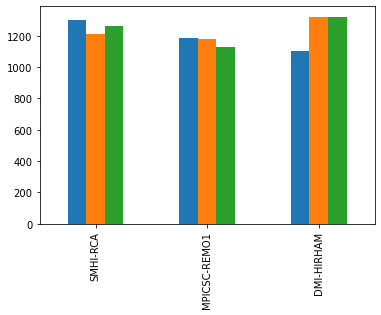

In [602]:
pd.DataFrame(mean_vals).sort_index().T.plot(kind = "bar", legend = False)

In [552]:

smhi_rca = xr.concat([xr.open_dataset(x) for x in model_outputs["SMHI-RCA"]], "variant")

[xr.open_dataset(model).to_array().mean().values for model in model_outputs["SMHI-RCA"]]


#df[0].mean(keep_attrs = None)["band_data"]

[array(1261.7417, dtype=float32),
 array(1211.1992, dtype=float32),
 array(1301.4664, dtype=float32)]